In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [5]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 52.2 s


# Loading Trajectories and Fields

In [6]:
from trajectories import *
positions = load_trajectories('positions_545.mat')
velocities = load_velocities('velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [7]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((make_interpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [8]:
del t, xT, yT, zT, xVelocity, yVelocity, zVelocity

In [9]:
from fields import *
c, intfun = fit_potential_xyz('potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz('potentialElectrodes.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Dropbox\Postdoc\Yale\CeNTREX Olivier\TlF Non-Adiabatic Transitions\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


# Propagation 20 Gauss

0.9953592718293781
Wall time: 1min 49s


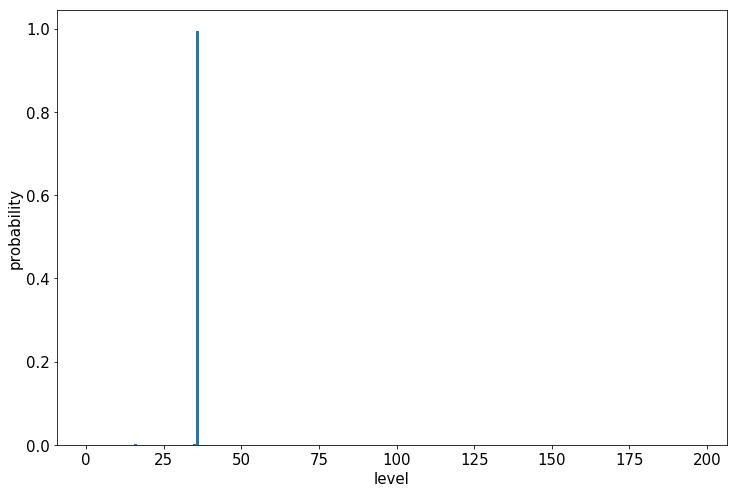

In [10]:
%%time 
from propagation import *
funB =  lambda x,y,z: (0, 20, 0)
funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[0], funE, funB, 35, 
                                    dtAdaptive = (5e-7, 1e-6), nstep = 2)

probabilities = calculate_state_probabilities(phi[-1], H[0])

fig, ax = plt.subplots(figsize = (12,8))
ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1)
ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

print(np.abs(phi[-1].conj()@phi[0])**2)

In [11]:
from order_eigenstates import *

In [12]:
%%time
energies, eigenvectors = np.linalg.eigh(H)

Wall time: 12.8 s


In [13]:
%%time
stride = 7
_, _, reorder = eigenshuffle(H[::stride], return_reorder = True)

Wall time: 3min 56s


In [14]:
%%time
energies, eigenvectors = reorder_full(energies,eigenvectors,reorder, stride)

Wall time: 756 ms


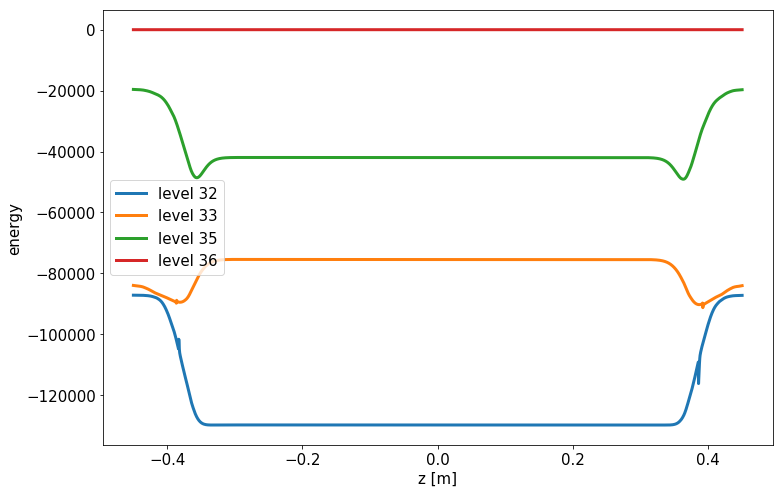

In [15]:
traj = interpolateTrajectories[0]

fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 0, len(t)
for l in [31,32,34,35]:
    ax.plot(traj[2](np.array(t))[nstart:nstop], energies[nstart:nstop,l]-energies[nstart:nstop,35], 
            label = 'level {0}'.format(l+1), lw = 3);
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

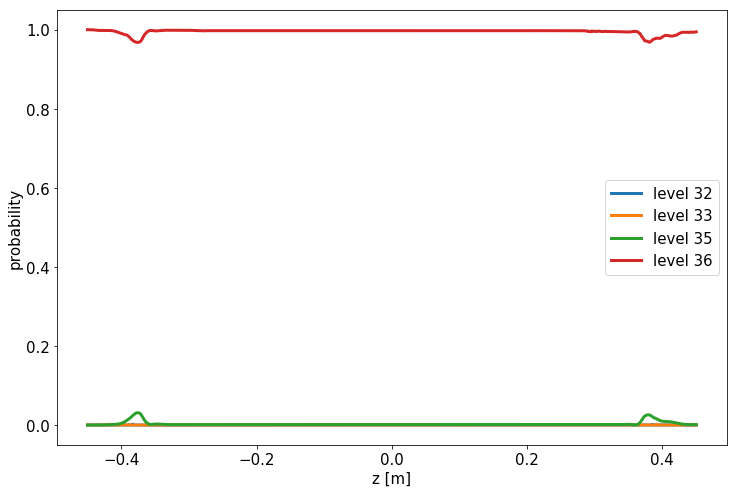

In [16]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phi, eigenvectors)

traj = interpolateTrajectories[0]

fig, ax = plt.subplots(figsize = (12,8))
for idL in [31,32,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del traj, idL

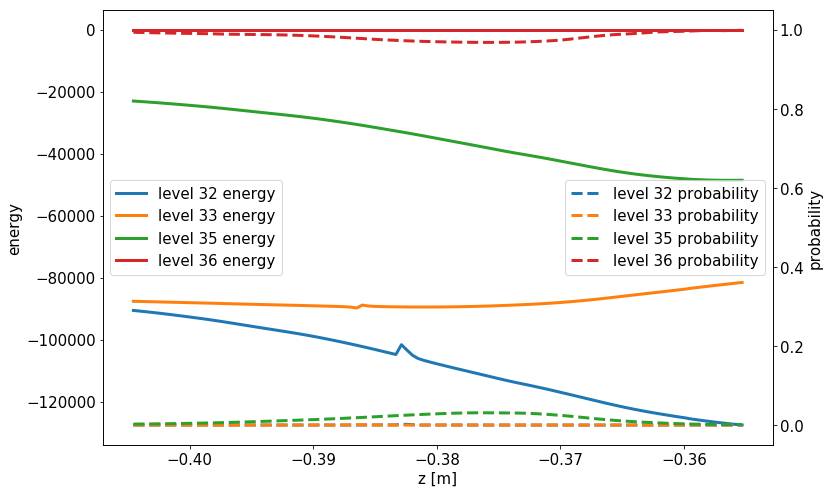

In [17]:
traj = interpolateTrajectories[0]

fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 100, 220
for idL in [31,32,34,35]:
    ax.plot(traj[2](t[nstart:nstop]), energies[nstart:nstop,idL]-energies[nstart:nstop,35], 
            label = 'level {0} energy'.format(idL+1), lw = 3);
ax.legend(loc = 6, fontsize = 15)
ax1 = ax.twinx()
for idL in [31,32,34,35]:
    ax1.plot(traj[2](t[nstart:nstop]), probabilities[nstart:nstop, idL], '--', lw = 3, 
             label = 'level {0} probability'.format(idL+1));
ax1.legend(loc = 5, fontsize = 15)
ax1.set_ylim(ymax = 1.05);
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
ax1.set_ylabel('probability')
set_fontsize(ax, 15)
set_fontsize(ax1, 15)
fig.savefig('levels_probability_earthfield.png', dpi = 150)

del traj, idL

# Checking a trajectory with significant reduction of probability

0.8359681765885895
Wall time: 2min 2s


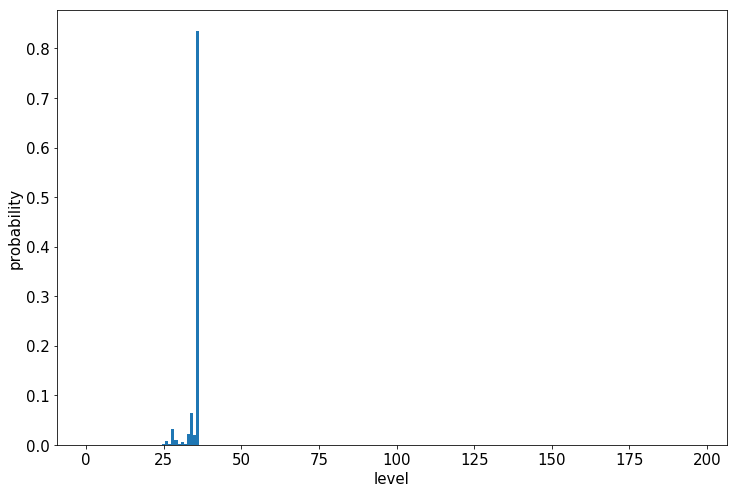

In [18]:
%%time 
from propagation import *
idT = 1
funB =  lambda x,y,z: (0, 20, 0)
funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, 35, 
                                    dtAdaptive = (5e-7, 1e-6), nstep = 2)

probabilities = calculate_state_probabilities(phi[-1], H[0])

fig, ax = plt.subplots(figsize = (12,8))
ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1)
ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

print(np.abs(phi[-1].conj()@phi[0])**2)

In [19]:
%%time
energies, eigenvectors = np.linalg.eigh(H)

Wall time: 14.5 s


In [20]:
%%time
stride = 7
_, _, reorder = eigenshuffle(H[::stride], return_reorder = True)

Wall time: 4min 17s


In [21]:
%%time
energies, eigenvectors = reorder_full(energies,eigenvectors,reorder, stride)

Wall time: 702 ms


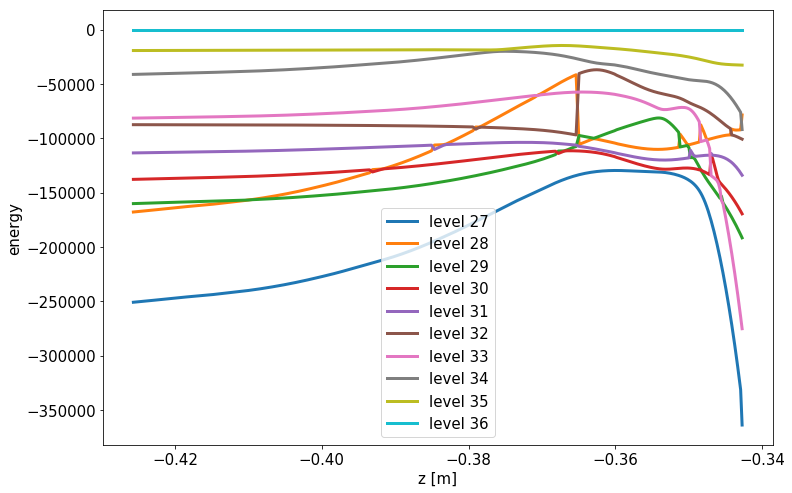

In [22]:
idT = 1
traj = interpolateTrajectories[idT]

fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 60, 310
for idL in range(26,36):
    ax.plot(traj[2](np.array(t))[nstart:nstop], energies[nstart:nstop,idL]-energies[nstart:nstop,35], 
            label = 'level {0}'.format(idL+1), lw = 3);
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

del traj, idT

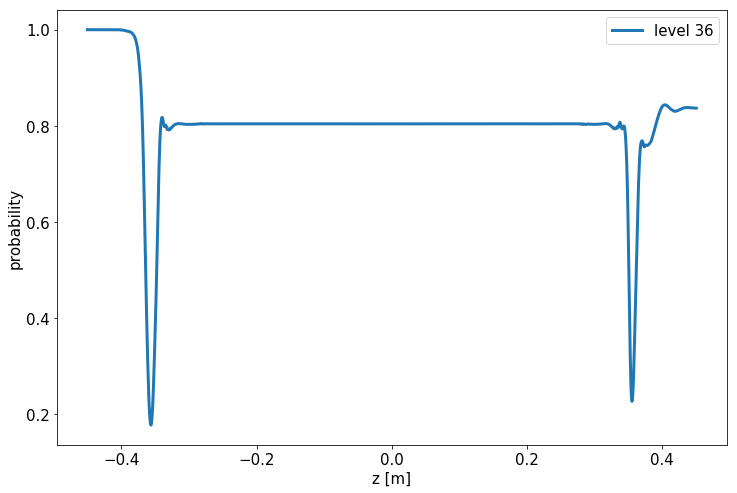

In [23]:
idT = 1
traj = interpolateTrajectories[idT]
probabilities = calculate_state_probabilities_eigvecs(phi, eigenvectors)

fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 0, len(t)
for idL in [35]:
    ax.plot(traj[2](np.array(t))[nstart:nstop], probabilities[nstart:nstop,idL], 
            label = 'level {0}'.format(idL+1), lw = 3);
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

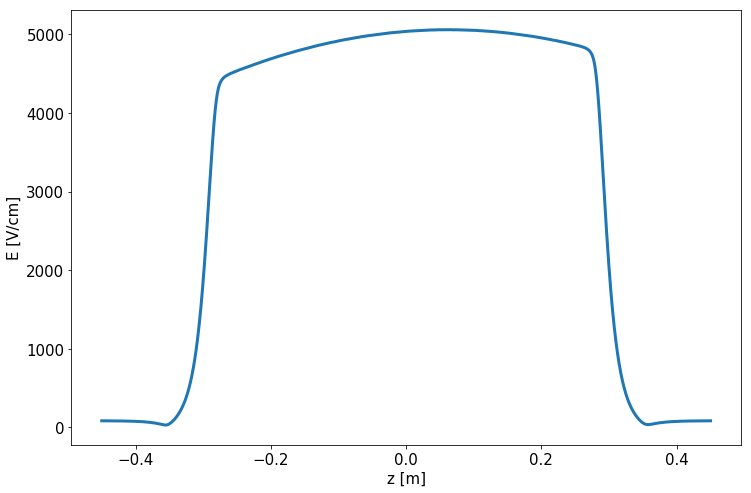

In [24]:
xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

nstart, nstop = 0,len(t)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi[nstart:nstop], funEmag(xi,yi,zi)[nstart:nstop], lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
set_fontsize(ax, 15)

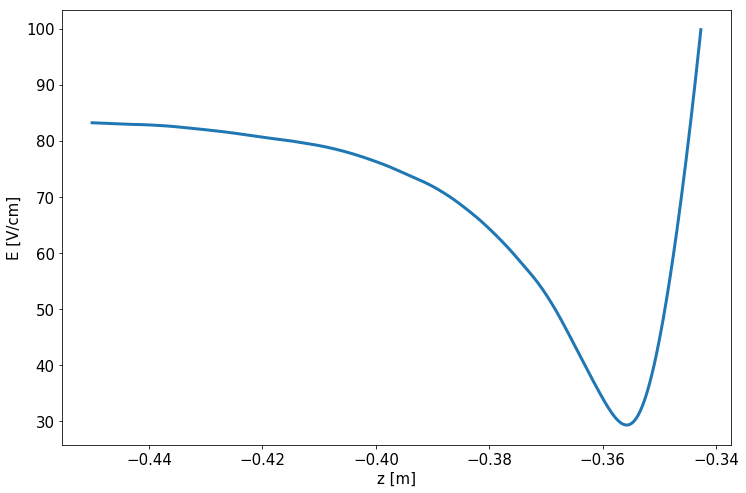

In [25]:
nstart, nstop = 0,310

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi[nstart:nstop], funEmag(xi,yi,zi)[nstart:nstop], lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
set_fontsize(ax, 15)

del nstart, nstop, idT, xi, yi, zi, traj, probabilities

# Check Effect of Magnetic Field Strength on Transfer Probability

In [26]:
idT = 1
traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](0), traj[1](0), traj[2](0)
B = [0.5,5,10,20,30,40,50,60,70,80,90,100]
Efactor = np.arange(0,5.5,.5)

for B0 in B:
    print('*'*50)
    print('{0} G'.format(B0))
    funE = lambda x,y,z: (0,0, funEmag(x,y,z))
    funB =  lambda x,y,z: (0, 0, B0)
    HamiltonianJ6.level_eigenstates(*funE(xi,yi,zi), *funB(xi,yi,zi), level = [33,34,35], epsilon = 0.99)

**************************************************
0.5 G
-----------------------
Level = 33
E = +4.0139742419271402e+07 kHz
	-1.000 +0.000i 2 +0 +0.5 +0.5
-----------------------
Level = 34
E = +4.0139744656782962e+07 kHz
	-1.000 +0.000i 2 +0 -0.5 -0.5
-----------------------
Level = 35
E = +4.0139752407777227e+07 kHz
	-1.000 +0.000i 2 +0 +0.5 -0.5
**************************************************
5 G
-----------------------
Level = 33
E = +4.0139732659462489e+07 kHz
	+1.000 +0.000i 2 +0 +0.5 +0.5
-----------------------
Level = 34
E = +4.0139754160820253e+07 kHz
	+1.000 +0.000i 2 +0 +0.5 -0.5
-----------------------
Level = 35
E = +4.0139754965450354e+07 kHz
	-1.000 +0.000i 2 +0 -0.5 -0.5
**************************************************
10 G
-----------------------
Level = 33
E = +4.0139722657026805e+07 kHz
	-1.000 +0.000i 2 +0 +0.5 +0.5
-----------------------
Level = 34
E = +4.0139758721864715e+07 kHz
	+1.000 +0.000i 2 +0 +0.5 -0.5
-----------------------
Level = 35
E = +4.013976

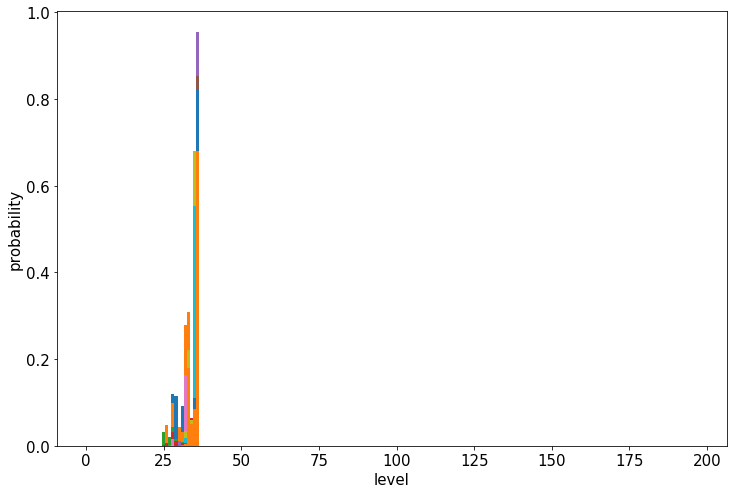

In [27]:
from tqdm import tqdm_notebook as tqdm
from propagation import *

idT = 1
fig, ax = plt.subplots(figsize = (12,8))
B = [0.5,5,10,20,30,40,50,60,70,80,90,100]
probabilities_magneticfield = []
for B0 in tqdm(B):
    from propagation import *
    funB =  lambda x,y,z: (0, B0, 0)
    funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
    t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, 35, 
                                        dtAdaptive = (5e-7, 1e-6), nstep = 2)

    probabilities = calculate_state_probabilities(phi[-1], H[0])

    ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1, label = '{0} G'.format(B0))
    probabilities_magneticfield.append(np.abs(phi[-1].conj()@phi[0])**2)

ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

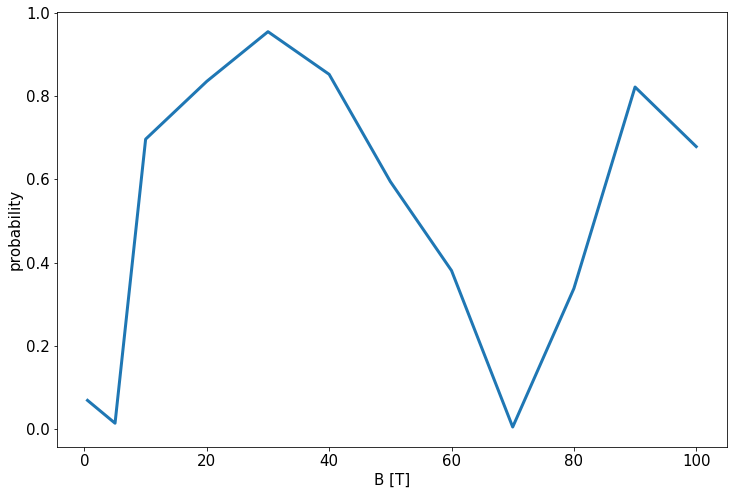

In [28]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(B, probabilities_magneticfield, lw = 3)
ax.set_xlabel('B [T]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

In [29]:
from tqdm import tqdm_notebook as tqdm

traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)
Exi, Eyi, Ezi = funEx(xi,yi,zi), funEy(xi,yi,zi), funEz(xi,yi,zi)
Bxi, Byi, Bzi = np.zeros(len(Exi)), np.ones(len(Exi)), np.zeros(len(Exi))

energies_magneticfield = []
eigenvectors_magneticfield = []

for B0 in tqdm(B):
    H = HamiltonianJ6.create_hamiltonian(Exi, Eyi, Ezi, Bxi, B0*Byi, Bzi)
    energies, eigenvectors = np.linalg.eigh(H)
    energies_magneticfield.append(energies)
    eigenvectors_magneticfield.append(eigenvectors)

In [30]:
from ipywidgets import interact, interactive, IntSlider

props = dict(boxstyle = 'round', facecolor = 'white', alpha = 1)
nstart, nstop =  0, len(t)
def update(idB):
    fig, ax = plt.subplots(figsize = (12,8))
    for idL in range(26,36):
        ax.plot(zi[nstart:nstop], energies_magneticfield[idB][:,idL][nstart:nstop] - \
                energies_magneticfield[idB][:,35][nstart:nstop], 
                lw = 3, label = 'level {0}'.format(idL+1))
    textstr = 'B = {0} G'.format(B[idB])
    ax.text(0.05, 0.08, textstr, transform=ax.transAxes, fontsize=15,
            va='top', bbox=props, ha = 'left')
    textstr = '{0:.1f}%'.format(probabilities_magneticfield[idB]*100)
    ax.text(0.95, 0.08, textstr, transform=ax.transAxes, fontsize=15,
            va='top', bbox=props, ha = 'right')
    ax.set_xlabel('z [m]')
    ax.set_ylabel('energy')
    ax.legend(fontsize = 15, loc = 8)
    set_fontsize(ax, 15)
    ax.set_ylim(ymin = -3e4, ymax = 1e3)
    fig.canvas.draw()

In [31]:
interact(update, idB = IntSlider(min=0,max=len(B)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='idB', max=11), Output()), _dom_classes=('widget-interact…